In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print(f"tf version is {tf.__version__}")
print(f"tfdf version is {tfdf.__version__}")

tf version is 2.17.1
tfdf version is 1.10.0


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [4]:
train_df = train_df.drop("PassengerId", axis = 1)

In [5]:
def preprocess(df):
    df = df.copy()
    def ticket_items(x):
        items = x.split(" ")
        if len(items) == 1:
            return "None"
        return " ".join(items[0:-1])
    def ticket_num(x):
        return x.split(" ")[-1]

    def cabin(x):
        return " ".join(x.split(" "))[0:1]
    def item(x):
        return " ".join(v.replace(".", "").replace("/", "") for v in x.split(" "))[0:3]

    def num(x):
        return " ".join(v.replace("LINE", "0") for v in x.split(" "))

    def age(x):
        if x < 10:
            return "0"
        elif x < 20:
            return "10"
        elif x < 30:
            return "20"
        elif x < 40:
            return "30"
        elif x < 50:
            return "40"
        elif x < 60:
            return "50"
        elif x < 70:
            return "60"
        elif x < 80:
            return "70"
        elif x < 90:
            return "80"
        elif x < 100:
            return "90"
        else:
            return "100"


    def normalize_name(x):
        return " ".join(v.strip("./"'()[]'"") for v in x.split(" "))

    def name(x):
        if any (title in x for title in ["Mrs", "Miss", "Ms", "Mme", "Mile"]):
            return "Mrs/Miss"

        elif "Mr" in x:
            return "Mr"
        elif "Master" in x:
            return "Master"
        else:
            return "others"

    def len_name(x):
        return len(" ".join(x.split(" ")))

    def is_alone(x):
        if x < 2:
            return "1"
        else:
            return "0"
            
            
    df["Ticket_items"] = df["Ticket"].apply(ticket_items)
    df["Ticket_number"] = df["Ticket"].apply(ticket_num)
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    df["Cabin"] = df["Cabin"].fillna("None")
    df["Cabin"] = df["Cabin"].apply(cabin)
    df["Ticket_items"] = df["Ticket_items"].apply(item)
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Ticket_number"] = df["Ticket_number"].apply(num)
    df["Ticket_number"] = df["Ticket_number"].astype(int)
    df["Age_categorical"] = df["Age"].apply(age)
    df["Age_categorical"] = df["Age_categorical"].astype(int)
    df["Family"] = (df["SibSp"] + df["Parch"] + 1)
    df["Len_Name"] = df["Name"].apply(len_name)
    df["Name"] = df["Name"].apply(normalize_name)
    df["Title"] = df["Name"].apply(name)
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())
    df["Categorical_Fare"] = pd.qcut(df["Fare"] / df["Family"], 4, labels = ["Low", "Mid", "High", "VeryHigh"])
    df["Categorical_Fare"] = df["Categorical_Fare"].map({"Low": 1, "Mid": 2, "High": 3, "VeryHigh": 4}).astype(int)
    df["Is_Alone"] = df["Family"].apply(is_alone).astype(int)
    df = df.drop("Name", axis = 1)
    df = df.drop("Age", axis = 1)
    df = df.drop("Ticket", axis = 1)

    

    cols = ("Embarked", "Cabin", "Ticket_items", "Title")
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)
    
    return df


train = preprocess(train_df)
train.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Ticket_items,Ticket_number,Age_categorical,Family,Len_Name,Title,Categorical_Fare,Is_Alone
0,0,3,0,1,0,7.2500,7,2,1,21171,20,2,23,1,1,0
1,1,1,1,1,0,71.2833,2,0,10,17599,30,2,51,2,4,0
2,1,3,1,0,0,7.9250,7,2,21,3101282,20,1,22,2,2,1
3,1,1,1,1,0,53.1000,2,2,9,113803,30,2,44,2,4,0
4,0,3,0,0,0,8.0500,7,2,9,373450,30,1,24,1,2,1
5,0,3,0,0,0,8.4583,7,1,9,330877,20,1,16,1,3,1
6,0,1,0,0,0,51.8625,4,2,9,17463,50,1,23,1,4,1
7,0,3,0,3,1,21.0750,7,2,9,349909,0,5,30,0,1,0
8,1,3,1,0,2,11.1333,7,2,9,347742,20,3,49,2,1,0
9,1,2,1,1,0,30.0708,7,0,9,237736,10,2,35,2,3,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    int64  
 1   Pclass            891 non-null    int64  
 2   Sex               891 non-null    int64  
 3   SibSp             891 non-null    int64  
 4   Parch             891 non-null    int64  
 5   Fare              891 non-null    float64
 6   Cabin             891 non-null    int64  
 7   Embarked          891 non-null    int64  
 8   Ticket_items      891 non-null    int64  
 9   Ticket_number     891 non-null    int64  
 10  Age_categorical   891 non-null    int64  
 11  Family            891 non-null    int64  
 12  Len_Name          891 non-null    int64  
 13  Title             891 non-null    int64  
 14  Categorical_Fare  891 non-null    int64  
 15  Is_Alone          891 non-null    int64  
dtypes: float64(1), int64(15)
memory usage: 111.5

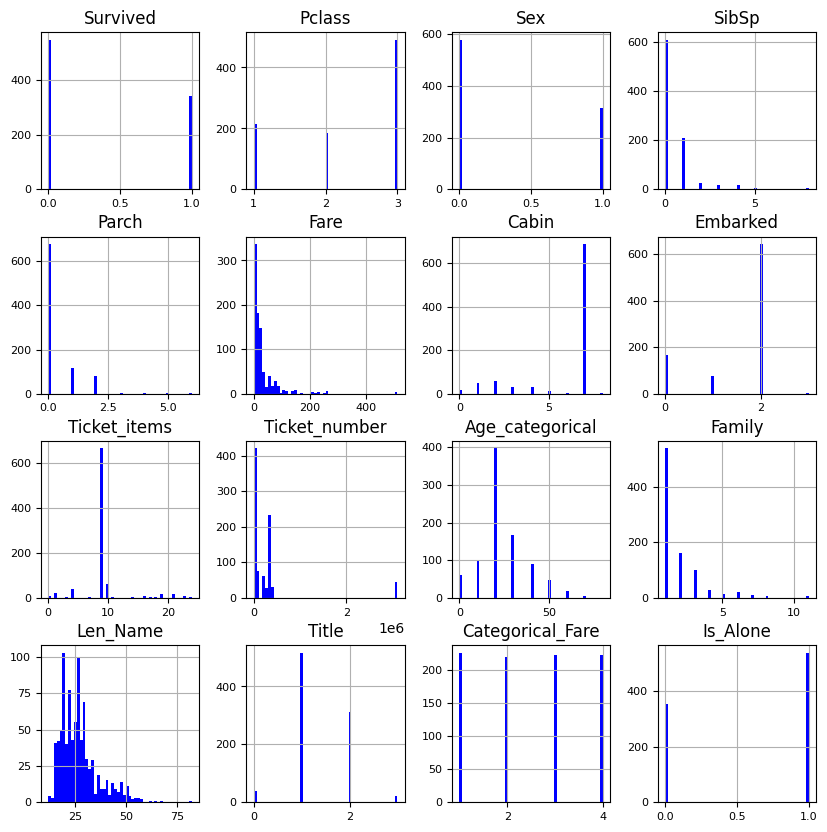

In [7]:
train.hist(figsize = (10,10), color = "b", bins = 50, xlabelsize = 8, ylabelsize = 8);

Index(['Survived', 'Pclass', 'Sex', 'Fare', 'Cabin', 'Len_Name', 'Title',
       'Categorical_Fare', 'Is_Alone'],
      dtype='object')


<Axes: >

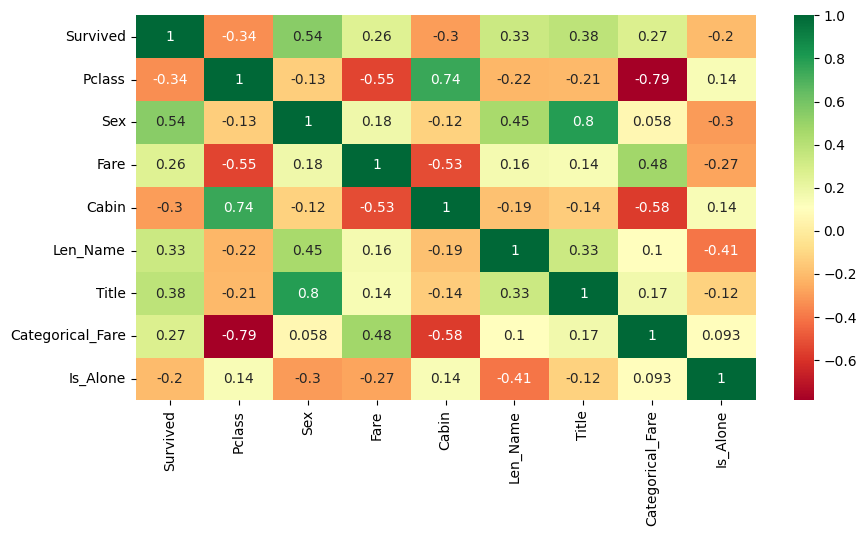

In [8]:
num_df = train.select_dtypes(["float64", "int64"])
corrmat = num_df.corr()
corr_cols = corrmat.index[abs(corrmat["Survived"])>=0.2]
print(train[corr_cols].columns)

plt.figure(figsize = (10,5))
sns.heatmap(num_df[corr_cols].corr(), annot = True, cmap = "RdYlGn")

In [9]:
target = train["Survived"]
selected = train.select_dtypes(["float64", "int64"])
selected = selected.drop("Survived", axis = 1)
x_data = sm.add_constant(selected, has_constant = "add")
ols = sm.OLS(target, x_data)
result = ols.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Survived   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     45.66
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           3.43e-94
Time:                        05:37:22   Log-Likelihood:                -377.84
No. Observations:                 891   AIC:                             785.7
Df Residuals:                     876   BIC:                             857.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6261      0.104      6.027      0.000       0.422       0.830
Pclass              -0.1164      0.032     -3.685      0.000      -0.178      -0.054
Sex                  0.6574      0.050     13.085      0.000       0.559       0.756
SibSp               -0.2367      0.038     -6.288      0.000      -0.311      -0.163
Parch               -0.2122      0.039     -5.392      0.000      -0.289      -0.135
Fare              4.446e-05      0.000      0.130      0.896      -0.001       0.001
Cabin               -0.0117      0.009     -1.254      0.210      -0.030       0.007
Embarked            -0.0399      0.017     -2.332      0.020      -0.073      -0.006
Ticket_items        -0.0031      0.004     -0.806      0.420      -0.011       0.005
Ticket_number     3.405e-08    2.3e-08      1.480      0.139   -1.11e-08    7.92e-08
Age_categorical     -0.0038      0.001     -3.590      0.000      -0.006      -0.002
Family               0.1772      0.033      5.429      0.000       0.113       0.241
Len_Name             0.0035      0.002      2.166      0.031       0.000       0.007
Title               -0.1747      0.037     -4.677      0.000      -0.248      -0.101
Categorical_Fare     0.0348      0.021      1.681      0.093      -0.006       0.075
Is_Alone            -0.0713      0.039     -1.821      0.069      -0.148       0.006
==============================================================================
Omnibus:                       36.013   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.345
Skew:                           0.506   Prob(JB):                     2.86e-09
Kurtosis:                       3.186   Cond. No.                     1.81e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.42e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<Axes: >

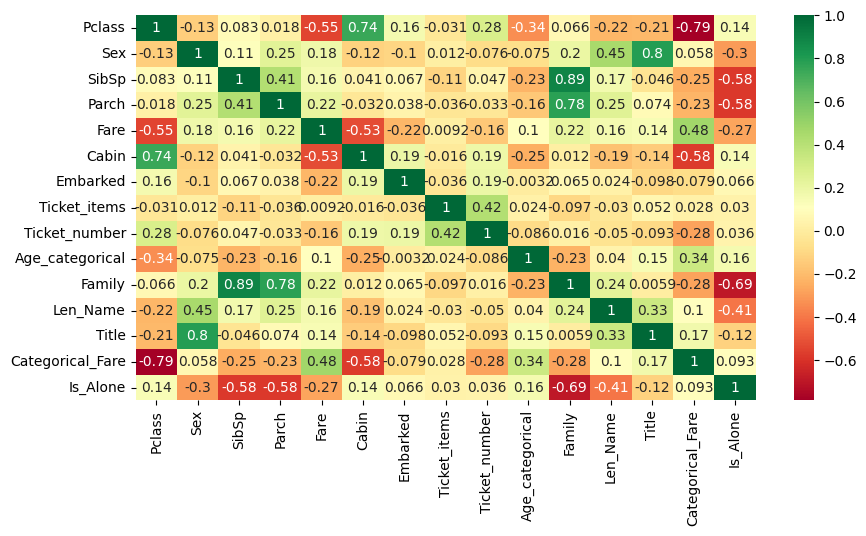

In [10]:
corrmat = selected.corr()

plt.figure(figsize = (10,5))
sns.heatmap(corrmat, annot = True, cmap = "RdYlGn")

In [11]:
train_dt, test_dt = train_test_split(
    train, test_size = 0.3, random_state = 1234
)

print("train size is {}, test size is {}".format(len(train_dt), len(test_dt)))

train size is 623, test size is 268


In [12]:
label = "Survived"
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_dt, label = label,
                                                task = tfdf.keras.Task.REGRESSION)

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dt, label = label,
                                               task = tfdf.keras.Task.REGRESSION)

tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [13]:
import optuna


def objective(trial):
    num_trees = trial.suggest_int("num_trees", 50, 1000, step = 50)
    max_depth = trial.suggest_int("max_depth", 5, 20, step = 5)
    min_examples = trial.suggest_int("min_examples", 2, 20, step = 2)
    rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION,
                                     num_trees = num_trees,
                                     max_depth = max_depth,
                                     min_examples = min_examples,
                                     random_seed = 1234)
    rf.compile(metrics = ["mse"])
    rf.fit(train_ds, verbose = 0)
    eval_results = rf.evaluate(x = test_ds, verbose = 0)
    return eval_results[0]

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 100)

print("Best Hyperparameters:", study.best_params)
    




[I 2025-01-31 05:37:24,054] A new study created in memory with name: no-name-97f3f35a-8708-4cb3-bc26-8793c8e2511b


Use /tmp/tmpy1lxe4pq as temporary training directory


[I 2025-01-31 05:37:31,258] Trial 0 finished with value: 0.0 and parameters: {'num_trees': 1000, 'max_depth': 20, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmpgcwwr9sm as temporary training directory


[I 2025-01-31 05:37:32,456] Trial 1 finished with value: 0.0 and parameters: {'num_trees': 750, 'max_depth': 15, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmp3wkcnh1_ as temporary training directory


[I 2025-01-31 05:37:33,232] Trial 2 finished with value: 0.0 and parameters: {'num_trees': 150, 'max_depth': 20, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmp1tx5i_7e as temporary training directory


[I 2025-01-31 05:37:34,563] Trial 3 finished with value: 0.0 and parameters: {'num_trees': 850, 'max_depth': 15, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmpz8chgho9 as temporary training directory


[I 2025-01-31 05:37:35,458] Trial 4 finished with value: 0.0 and parameters: {'num_trees': 850, 'max_depth': 5, 'min_examples': 20}. Best is trial 0 with value: 0.0.


Use /tmp/tmp1c9ku6qh as temporary training directory


[I 2025-01-31 05:37:36,765] Trial 5 finished with value: 0.0 and parameters: {'num_trees': 750, 'max_depth': 10, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmp086_3qfn as temporary training directory


[I 2025-01-31 05:37:37,643] Trial 6 finished with value: 0.0 and parameters: {'num_trees': 350, 'max_depth': 15, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmp2eoopa53 as temporary training directory


[I 2025-01-31 05:37:38,462] Trial 7 finished with value: 0.0 and parameters: {'num_trees': 650, 'max_depth': 5, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmpf4d59o34 as temporary training directory


[I 2025-01-31 05:37:39,149] Trial 8 finished with value: 0.0 and parameters: {'num_trees': 250, 'max_depth': 5, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmpd1scty06 as temporary training directory


[I 2025-01-31 05:37:40,193] Trial 9 finished with value: 0.0 and parameters: {'num_trees': 550, 'max_depth': 20, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmplm2o5zkk as temporary training directory


[I 2025-01-31 05:37:41,467] Trial 10 finished with value: 0.0 and parameters: {'num_trees': 1000, 'max_depth': 20, 'min_examples': 18}. Best is trial 0 with value: 0.0.


Use /tmp/tmphaxon2g8 as temporary training directory


[I 2025-01-31 05:37:42,797] Trial 11 finished with value: 0.0 and parameters: {'num_trees': 1000, 'max_depth': 15, 'min_examples': 16}. Best is trial 0 with value: 0.0.


Use /tmp/tmpt0uozk7g as temporary training directory


[I 2025-01-31 05:37:44,013] Trial 12 finished with value: 0.0 and parameters: {'num_trees': 850, 'max_depth': 10, 'min_examples': 16}. Best is trial 0 with value: 0.0.


Use /tmp/tmpxtpk6qmt as temporary training directory


[I 2025-01-31 05:37:45,180] Trial 13 finished with value: 0.0 and parameters: {'num_trees': 450, 'max_depth': 20, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmpwsp0ngv4 as temporary training directory


[I 2025-01-31 05:37:46,312] Trial 14 finished with value: 0.0 and parameters: {'num_trees': 700, 'max_depth': 15, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmptw7a9763 as temporary training directory


[I 2025-01-31 05:37:48,067] Trial 15 finished with value: 0.0 and parameters: {'num_trees': 1000, 'max_depth': 10, 'min_examples': 2}. Best is trial 0 with value: 0.0.


Use /tmp/tmpriczqtra as temporary training directory


[I 2025-01-31 05:37:49,757] Trial 16 finished with value: 0.0 and parameters: {'num_trees': 850, 'max_depth': 20, 'min_examples': 16}. Best is trial 0 with value: 0.0.


Use /tmp/tmppuryo47e as temporary training directory


[I 2025-01-31 05:37:50,891] Trial 17 finished with value: 0.0 and parameters: {'num_trees': 550, 'max_depth': 15, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmpclux1sr2 as temporary training directory


[I 2025-01-31 05:37:52,080] Trial 18 finished with value: 0.0 and parameters: {'num_trees': 750, 'max_depth': 20, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmpmqd56e8u as temporary training directory


[I 2025-01-31 05:37:53,253] Trial 19 finished with value: 0.0 and parameters: {'num_trees': 900, 'max_depth': 15, 'min_examples': 20}. Best is trial 0 with value: 0.0.


Use /tmp/tmpljovrij8 as temporary training directory


[I 2025-01-31 05:37:54,399] Trial 20 finished with value: 0.0 and parameters: {'num_trees': 650, 'max_depth': 10, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmp674pv746 as temporary training directory


[I 2025-01-31 05:37:55,176] Trial 21 finished with value: 0.0 and parameters: {'num_trees': 150, 'max_depth': 20, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmpeor_rkwl as temporary training directory


[I 2025-01-31 05:37:55,935] Trial 22 finished with value: 0.0 and parameters: {'num_trees': 100, 'max_depth': 20, 'min_examples': 2}. Best is trial 0 with value: 0.0.


Use /tmp/tmp1k4rxdn6 as temporary training directory


[I 2025-01-31 05:37:56,833] Trial 23 finished with value: 0.0 and parameters: {'num_trees': 400, 'max_depth': 20, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmpblawdjhk as temporary training directory


[I 2025-01-31 05:37:57,515] Trial 24 finished with value: 0.0 and parameters: {'num_trees': 50, 'max_depth': 15, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmpvfro0l00 as temporary training directory


[I 2025-01-31 05:37:58,391] Trial 25 finished with value: 0.0 and parameters: {'num_trees': 300, 'max_depth': 20, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmp211_h2xm as temporary training directory


[I 2025-01-31 05:37:59,186] Trial 26 finished with value: 0.0 and parameters: {'num_trees': 200, 'max_depth': 15, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmphr6g_rhj as temporary training directory


[I 2025-01-31 05:38:00,166] Trial 27 finished with value: 0.0 and parameters: {'num_trees': 500, 'max_depth': 20, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmplw188s7k as temporary training directory


[I 2025-01-31 05:38:01,165] Trial 28 finished with value: 0.0 and parameters: {'num_trees': 600, 'max_depth': 20, 'min_examples': 18}. Best is trial 0 with value: 0.0.


Use /tmp/tmpucwywk1a as temporary training directory


[I 2025-01-31 05:38:02,718] Trial 29 finished with value: 0.0 and parameters: {'num_trees': 750, 'max_depth': 15, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmp_1osl91i as temporary training directory


[I 2025-01-31 05:38:04,128] Trial 30 finished with value: 0.0 and parameters: {'num_trees': 900, 'max_depth': 15, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmprt5lrdx1 as temporary training directory


[I 2025-01-31 05:38:05,447] Trial 31 finished with value: 0.0 and parameters: {'num_trees': 900, 'max_depth': 15, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmp4o8mhpqz as temporary training directory


[I 2025-01-31 05:38:06,669] Trial 32 finished with value: 0.0 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmp0kqick1u as temporary training directory


[I 2025-01-31 05:38:08,436] Trial 33 finished with value: 0.0 and parameters: {'num_trees': 950, 'max_depth': 15, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmpl_nt1_no as temporary training directory


[I 2025-01-31 05:38:09,571] Trial 34 finished with value: 0.0 and parameters: {'num_trees': 800, 'max_depth': 20, 'min_examples': 18}. Best is trial 0 with value: 0.0.


Use /tmp/tmpfd92q7q5 as temporary training directory


[I 2025-01-31 05:38:10,503] Trial 35 finished with value: 0.0 and parameters: {'num_trees': 950, 'max_depth': 5, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmptws24nu9 as temporary training directory


[I 2025-01-31 05:38:11,652] Trial 36 finished with value: 0.0 and parameters: {'num_trees': 650, 'max_depth': 10, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmp0zjp4wd7 as temporary training directory


[I 2025-01-31 05:38:13,126] Trial 37 finished with value: 0.0 and parameters: {'num_trees': 800, 'max_depth': 15, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmpnv4ytjii as temporary training directory


[I 2025-01-31 05:38:14,429] Trial 38 finished with value: 0.0 and parameters: {'num_trees': 950, 'max_depth': 15, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmpsejbbvl0 as temporary training directory


[I 2025-01-31 05:38:15,320] Trial 39 finished with value: 0.0 and parameters: {'num_trees': 350, 'max_depth': 20, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmp0fd0eibo as temporary training directory


[I 2025-01-31 05:38:16,933] Trial 40 finished with value: 0.0 and parameters: {'num_trees': 700, 'max_depth': 5, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmphgkhuev5 as temporary training directory


[I 2025-01-31 05:38:17,950] Trial 41 finished with value: 0.0 and parameters: {'num_trees': 850, 'max_depth': 5, 'min_examples': 16}. Best is trial 0 with value: 0.0.


Use /tmp/tmp_nflqd2m as temporary training directory


[I 2025-01-31 05:38:19,202] Trial 42 finished with value: 0.0 and parameters: {'num_trees': 1000, 'max_depth': 10, 'min_examples': 20}. Best is trial 0 with value: 0.0.


Use /tmp/tmp5mc2cs78 as temporary training directory


[I 2025-01-31 05:38:20,086] Trial 43 finished with value: 0.0 and parameters: {'num_trees': 750, 'max_depth': 5, 'min_examples': 20}. Best is trial 0 with value: 0.0.


Use /tmp/tmp77xrjp4w as temporary training directory


[I 2025-01-31 05:38:21,258] Trial 44 finished with value: 0.0 and parameters: {'num_trees': 850, 'max_depth': 10, 'min_examples': 16}. Best is trial 0 with value: 0.0.


Use /tmp/tmpisufmglx as temporary training directory


[I 2025-01-31 05:38:22,510] Trial 45 finished with value: 0.0 and parameters: {'num_trees': 950, 'max_depth': 15, 'min_examples': 18}. Best is trial 0 with value: 0.0.


Use /tmp/tmpe24dknlv as temporary training directory


[I 2025-01-31 05:38:23,731] Trial 46 finished with value: 0.0 and parameters: {'num_trees': 700, 'max_depth': 20, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmpa0r6w547 as temporary training directory


[I 2025-01-31 05:38:25,171] Trial 47 finished with value: 0.0 and parameters: {'num_trees': 900, 'max_depth': 15, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmpe7atx15k as temporary training directory


[I 2025-01-31 05:38:26,311] Trial 48 finished with value: 0.0 and parameters: {'num_trees': 500, 'max_depth': 20, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmp0nog2sea as temporary training directory


[I 2025-01-31 05:38:27,116] Trial 49 finished with value: 0.0 and parameters: {'num_trees': 250, 'max_depth': 10, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmpkoup_2pt as temporary training directory


[I 2025-01-31 05:38:27,945] Trial 50 finished with value: 0.0 and parameters: {'num_trees': 600, 'max_depth': 5, 'min_examples': 2}. Best is trial 0 with value: 0.0.


Use /tmp/tmpvxvf4snt as temporary training directory


[I 2025-01-31 05:38:29,323] Trial 51 finished with value: 0.0 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmpasjf8vhf as temporary training directory


[I 2025-01-31 05:38:30,221] Trial 52 finished with value: 0.0 and parameters: {'num_trees': 750, 'max_depth': 5, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmpftm5wro8 as temporary training directory


[I 2025-01-31 05:38:31,631] Trial 53 finished with value: 0.0 and parameters: {'num_trees': 850, 'max_depth': 10, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmpnz4hqx4f as temporary training directory


[I 2025-01-31 05:38:33,214] Trial 54 finished with value: 0.0 and parameters: {'num_trees': 650, 'max_depth': 15, 'min_examples': 2}. Best is trial 0 with value: 0.0.


Use /tmp/tmpwu857zxw as temporary training directory


[I 2025-01-31 05:38:34,630] Trial 55 finished with value: 0.0 and parameters: {'num_trees': 1000, 'max_depth': 20, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmpiiyzg7iz as temporary training directory


[I 2025-01-31 05:38:36,077] Trial 56 finished with value: 0.0 and parameters: {'num_trees': 700, 'max_depth': 15, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmpsg61_ilr as temporary training directory


[I 2025-01-31 05:38:37,081] Trial 57 finished with value: 0.0 and parameters: {'num_trees': 450, 'max_depth': 20, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmpc_iwfyal as temporary training directory


[I 2025-01-31 05:38:38,424] Trial 58 finished with value: 0.0 and parameters: {'num_trees': 850, 'max_depth': 10, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmpu1dbv3z7 as temporary training directory


[I 2025-01-31 05:38:39,692] Trial 59 finished with value: 0.0 and parameters: {'num_trees': 900, 'max_depth': 20, 'min_examples': 16}. Best is trial 0 with value: 0.0.


Use /tmp/tmp93qwrl9k as temporary training directory


[I 2025-01-31 05:38:40,887] Trial 60 finished with value: 0.0 and parameters: {'num_trees': 600, 'max_depth': 15, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmpz6npma27 as temporary training directory


[I 2025-01-31 05:38:41,580] Trial 61 finished with value: 0.0 and parameters: {'num_trees': 50, 'max_depth': 15, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmpuvq2gs1n as temporary training directory


[I 2025-01-31 05:38:42,463] Trial 62 finished with value: 0.0 and parameters: {'num_trees': 300, 'max_depth': 15, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmpoaz98rel as temporary training directory


[I 2025-01-31 05:38:43,231] Trial 63 finished with value: 0.0 and parameters: {'num_trees': 150, 'max_depth': 15, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmpfozuoazm as temporary training directory


[I 2025-01-31 05:38:44,177] Trial 64 finished with value: 0.0 and parameters: {'num_trees': 400, 'max_depth': 20, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmpejw_d9i0 as temporary training directory


[I 2025-01-31 05:38:44,979] Trial 65 finished with value: 0.0 and parameters: {'num_trees': 200, 'max_depth': 15, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmpah5nym3g as temporary training directory


[I 2025-01-31 05:38:47,280] Trial 66 finished with value: 0.0 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmpdjhxyors as temporary training directory


[I 2025-01-31 05:38:47,999] Trial 67 finished with value: 0.0 and parameters: {'num_trees': 100, 'max_depth': 5, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmpvexr9qgt as temporary training directory


[I 2025-01-31 05:38:49,233] Trial 68 finished with value: 0.0 and parameters: {'num_trees': 550, 'max_depth': 15, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmplopqfm9r as temporary training directory


[I 2025-01-31 05:38:50,162] Trial 69 finished with value: 0.0 and parameters: {'num_trees': 300, 'max_depth': 20, 'min_examples': 16}. Best is trial 0 with value: 0.0.


Use /tmp/tmp8l4so8sl as temporary training directory


[I 2025-01-31 05:38:51,575] Trial 70 finished with value: 0.0 and parameters: {'num_trees': 750, 'max_depth': 15, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmp2dw8_n6b as temporary training directory


[I 2025-01-31 05:38:52,475] Trial 71 finished with value: 0.0 and parameters: {'num_trees': 650, 'max_depth': 5, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmp4jbp_tbd as temporary training directory


[I 2025-01-31 05:38:53,368] Trial 72 finished with value: 0.0 and parameters: {'num_trees': 750, 'max_depth': 5, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmpi0m4akql as temporary training directory


[I 2025-01-31 05:38:54,245] Trial 73 finished with value: 0.0 and parameters: {'num_trees': 700, 'max_depth': 5, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmpxgaf6mkk as temporary training directory


[I 2025-01-31 05:38:55,151] Trial 74 finished with value: 0.0 and parameters: {'num_trees': 800, 'max_depth': 5, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmpdd2vjzr6 as temporary training directory


[I 2025-01-31 05:38:56,113] Trial 75 finished with value: 0.0 and parameters: {'num_trees': 950, 'max_depth': 5, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmp9hk0uwlz as temporary training directory


[I 2025-01-31 05:38:57,156] Trial 76 finished with value: 0.0 and parameters: {'num_trees': 650, 'max_depth': 10, 'min_examples': 18}. Best is trial 0 with value: 0.0.


Use /tmp/tmpasa5e74z as temporary training directory


[I 2025-01-31 05:38:58,361] Trial 77 finished with value: 0.0 and parameters: {'num_trees': 800, 'max_depth': 20, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmp0obsgj4x as temporary training directory


[I 2025-01-31 05:38:59,370] Trial 78 finished with value: 0.0 and parameters: {'num_trees': 600, 'max_depth': 10, 'min_examples': 20}. Best is trial 0 with value: 0.0.


Use /tmp/tmp2xraimak as temporary training directory


[I 2025-01-31 05:39:00,830] Trial 79 finished with value: 0.0 and parameters: {'num_trees': 900, 'max_depth': 15, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmpgm0q1i04 as temporary training directory


[I 2025-01-31 05:39:01,859] Trial 80 finished with value: 0.0 and parameters: {'num_trees': 450, 'max_depth': 20, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmpaets4yn0 as temporary training directory


[I 2025-01-31 05:39:02,603] Trial 81 finished with value: 0.0 and parameters: {'num_trees': 200, 'max_depth': 5, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmp9biaqv3f as temporary training directory


[I 2025-01-31 05:39:03,333] Trial 82 finished with value: 0.0 and parameters: {'num_trees': 250, 'max_depth': 5, 'min_examples': 2}. Best is trial 0 with value: 0.0.


Use /tmp/tmpyxndf1a3 as temporary training directory


[I 2025-01-31 05:39:04,003] Trial 83 finished with value: 0.0 and parameters: {'num_trees': 100, 'max_depth': 5, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmpop4zb5ed as temporary training directory


[I 2025-01-31 05:39:04,703] Trial 84 finished with value: 0.0 and parameters: {'num_trees': 150, 'max_depth': 5, 'min_examples': 6}. Best is trial 0 with value: 0.0.


Use /tmp/tmpzfzep4p6 as temporary training directory


[I 2025-01-31 05:39:05,440] Trial 85 finished with value: 0.0 and parameters: {'num_trees': 250, 'max_depth': 5, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmpfig0zv9e as temporary training directory


[I 2025-01-31 05:39:06,323] Trial 86 finished with value: 0.0 and parameters: {'num_trees': 350, 'max_depth': 10, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmpc99efnud as temporary training directory


[I 2025-01-31 05:39:07,517] Trial 87 finished with value: 0.0 and parameters: {'num_trees': 850, 'max_depth': 15, 'min_examples': 18}. Best is trial 0 with value: 0.0.


Use /tmp/tmpszqh8w6s as temporary training directory


[I 2025-01-31 05:39:08,507] Trial 88 finished with value: 0.0 and parameters: {'num_trees': 1000, 'max_depth': 5, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmpxtgogutl as temporary training directory


[I 2025-01-31 05:39:09,992] Trial 89 finished with value: 0.0 and parameters: {'num_trees': 700, 'max_depth': 20, 'min_examples': 4}. Best is trial 0 with value: 0.0.


Use /tmp/tmp19o2r0zs as temporary training directory


[I 2025-01-31 05:39:10,732] Trial 90 finished with value: 0.0 and parameters: {'num_trees': 100, 'max_depth': 15, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmp9m0i31rz as temporary training directory


[I 2025-01-31 05:39:11,784] Trial 91 finished with value: 0.0 and parameters: {'num_trees': 550, 'max_depth': 20, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmpmi6ccs_1 as temporary training directory


[I 2025-01-31 05:39:12,871] Trial 92 finished with value: 0.0 and parameters: {'num_trees': 500, 'max_depth': 20, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmp87bjuuge as temporary training directory


[I 2025-01-31 05:39:13,895] Trial 93 finished with value: 0.0 and parameters: {'num_trees': 550, 'max_depth': 20, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmp1pq_vo7x as temporary training directory


[I 2025-01-31 05:39:15,888] Trial 94 finished with value: 0.0 and parameters: {'num_trees': 750, 'max_depth': 20, 'min_examples': 12}. Best is trial 0 with value: 0.0.


Use /tmp/tmpreuv9mnq as temporary training directory


[I 2025-01-31 05:39:16,992] Trial 95 finished with value: 0.0 and parameters: {'num_trees': 400, 'max_depth': 20, 'min_examples': 8}. Best is trial 0 with value: 0.0.


Use /tmp/tmp2xsw72_o as temporary training directory


[I 2025-01-31 05:39:17,979] Trial 96 finished with value: 0.0 and parameters: {'num_trees': 350, 'max_depth': 20, 'min_examples': 10}. Best is trial 0 with value: 0.0.


Use /tmp/tmpsfntq2gy as temporary training directory


[I 2025-01-31 05:39:19,085] Trial 97 finished with value: 0.0 and parameters: {'num_trees': 600, 'max_depth': 15, 'min_examples': 14}. Best is trial 0 with value: 0.0.


Use /tmp/tmp3_f14r13 as temporary training directory


[I 2025-01-31 05:39:20,101] Trial 98 finished with value: 0.0 and parameters: {'num_trees': 950, 'max_depth': 5, 'min_examples': 2}. Best is trial 0 with value: 0.0.


Use /tmp/tmp1dd6du34 as temporary training directory


[I 2025-01-31 05:39:21,179] Trial 99 finished with value: 0.0 and parameters: {'num_trees': 450, 'max_depth': 20, 'min_examples': 16}. Best is trial 0 with value: 0.0.


Best Hyperparameters: {'num_trees': 1000, 'max_depth': 20, 'min_examples': 14}


In [14]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, 
                                 num_trees = 550,
                                 max_depth = 5,
                                 min_examples = 14,
                                 random_seed = 1234)
rf.compile(metrics = ["mse"])
rf.fit(x = train_ds)

Use /tmp/tmplh3fcr89 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.332202. Found 623 examples.
Training model...
Model trained in 0:00:00.221800
Compiling model...
Model compiled.


In [15]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx = 0, max_depth = 3)

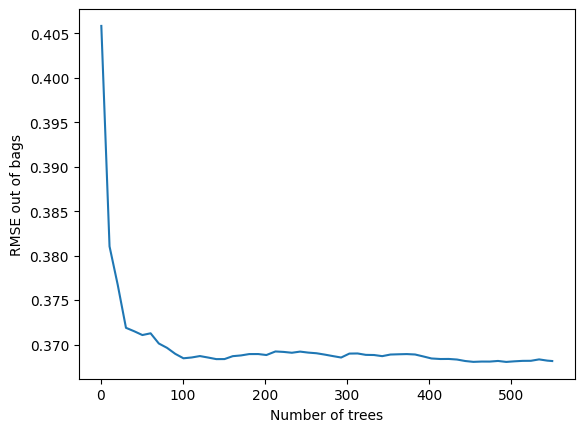

In [16]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE out of bags")
plt.show()

In [17]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=623, accuracy=None, loss=None, rmse=0.36814281510282876, ndcg=None, aucs=None, auuc=None, qini=None)

In [18]:
evaluation = rf.evaluate(x = test_ds, return_dict = True)
for name, value in evaluation.items():
    print(f"{name}, {value:.4f}")

1/1 [==============================] - 0s 133ms/step - loss: 0.0000e+00 - mse: 0.1238
loss, 0.0000
mse, 0.1238


In [19]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

Available variable importances:
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE


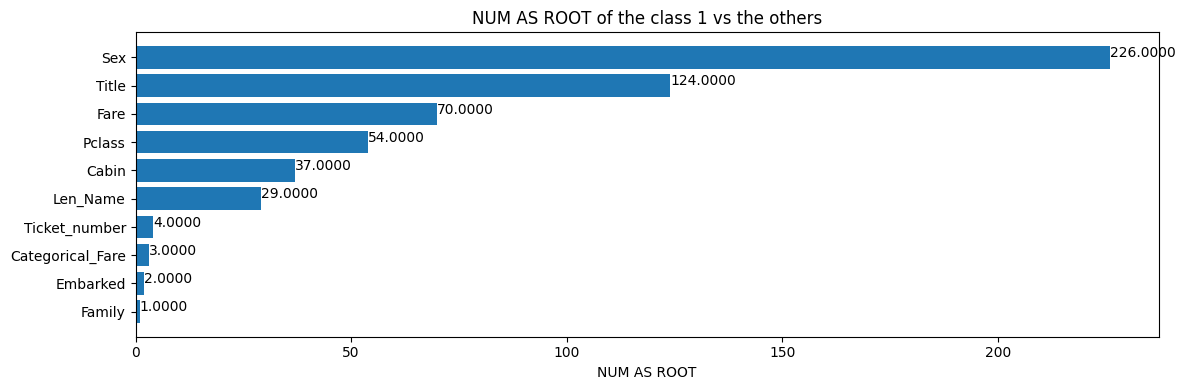

In [20]:
plt.figure(figsize = (12,4))

variable_importances = inspector.variable_importances()["NUM_AS_ROOT"]

feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label = [str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va = "top")

plt.xlabel("NUM AS ROOT")
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [21]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
ids = test_data.pop("PassengerId")

test_df = preprocess(test_data)
test_df.info()

test = tfdf.keras.pd_dataframe_to_tf_dataset(test_df,
                                            task = tfdf.keras.Task.REGRESSION)

pred = (rf.predict(test) >=0.5).astype(int)
output = pd.DataFrame({"PassengerId": ids, "Survived": pred.squeeze()})
output.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Pclass            418 non-null    int64  
 1   Sex               418 non-null    int64  
 2   SibSp             418 non-null    int64  
 3   Parch             418 non-null    int64  
 4   Fare              418 non-null    float64
 5   Cabin             418 non-null    int64  
 6   Embarked          418 non-null    int64  
 7   Ticket_items      418 non-null    int64  
 8   Ticket_number     418 non-null    int64  
 9   Age_categorical   418 non-null    int64  
 10  Family            418 non-null    int64  
 11  Len_Name          418 non-null    int64  
 12  Title             418 non-null    int64  
 13  Categorical_Fare  418 non-null    int64  
 14  Is_Alone          418 non-null    int64  
dtypes: float64(1), int64(14)
memory usage: 49.1 KB
1/1 [==============================] - 0s 61

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [22]:
submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
submission["Survived"] = pred
submission.to_csv("/kaggle/working/submission20.csv", index = False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
